In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from requests_html import AsyncHTMLSession, HTMLSession
from bs4 import BeautifulSoup
import asyncio
import logging
import json
import re

logging.disable(logging.WARNING)

ed2_range = range(117910, 251508)

C:\Users\kalls\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\kalls\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transfo

In [2]:
def debug_print(message, debug=True):
    
    if debug:
        print(message)

def convert_keys_to_int(json_dict):
    
    return { (int(key) if key.isdigit() else key): value for key, value in json_dict.items() }

def filter_entries(entries, edition=None, articles=None):
    
    if edition:
        entries = entries.get(edition, {})
    
        if articles:
            entries = { article: item for article, item in entries.items() if article in articles}

    return entries

def load_json(path, edition=None, articles=None):
    
    try:
        with open(path + '.json', 'r', encoding='utf-8') as file:
            return filter_entries(json.load(file, object_hook=convert_keys_to_int), edition, articles)

    except (FileNotFoundError, json.JSONDecodeError):
        with open(path + '.json', 'w', encoding='utf-8') as file:
            json.dump({ }, file, ensure_ascii=False, indent=4)
        return { }

def save_json(path, entries, edition=None, reset=False, sort_keys=False):
    
    temp_entries = entries   
    entries = ({ edition: { } } if edition else { }) if reset else load_json(path)

    entries.setdefault(edition, {})
    
    (entries[edition] if edition else entries).update(temp_entries)
    
    try:
        with open(path + '.json', 'w', encoding='utf-8') as file:
            json.dump(entries, file, ensure_ascii=False, indent=4, sort_keys=sort_keys)

    except:
        pass
        
def find_missing_articles(edition, articles, path):

    return articles - load_json(path).get(edition, { }).keys()

In [3]:
async def fetch_article(
    edition, article, session=AsyncHTMLSession(), semaphore=asyncio.Semaphore(), max_tries=3, debug=False):
    
    url = f'https://nordiskfamiljebok.dh.gu.se/article/{edition}/{(article if edition == 1 else article + ed2_range[0] - 1)}'
    
    async with semaphore:

        debug_print(f"Fetching {'1st' if article == 1 else f'{article}nd'} article from {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
        
        for n in range(1, max_tries + 1):
            try:
                response = await session.get(url)
                await response.html.arender(timeout=5*n, sleep=n/10)
                
                soup = BeautifulSoup(response.html.html, "html.parser")
                
                entry = {
                    'url': url,
                    'title': soup.find('h1', {'data-v-5ad7308b': True}).decode_contents(),
                    'text': soup.find('article', {'data-v-5ad7308b': True}).decode_contents()
                }
                debug_print(f"Successfully fetched and rendered article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
                
                return entry
                
            except:
                debug_print(f"Failed to fetch or render article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition.\nRetrying with larger timeout...", debug)
    
    debug_print(f"Failed to fetch article {article}, {'1st' if edition == 1 else f'{edition}nd'} edition", debug)
     
    return None

async def load_articles(
    edition, articles, path='articles', force_fetch=False,
    max_concurrent_tasks=5, max_tries=3, logging_step=20,
    sort=True, get_all=True, debug=False):
    
    articles_to_fetch = articles if force_fetch else find_missing_articles(edition, articles, path)

    debug_print(f'{len(articles)} articles to fetch: {articles}', debug)
    
    if logging_step > 0:
        articles_to_fetch = list(articles_to_fetch)
        articles_list = [articles_to_fetch[i:i + logging_step] for i in range(0, len(articles_to_fetch), logging_step)]
  
    else:
        articles_list = [[articles]]

    session = AsyncHTMLSession()
    semaphore = asyncio.Semaphore(max_concurrent_tasks)
    
    entries = load_json(path)
    entries.setdefault(edition, { })
        
    for i, article_list in enumerate(articles_list, 1):
        debug_print(f'Step {i}/{len(articles_list)}\nArticles: {article_list}\n')
        
        async with asyncio.TaskGroup() as task_group:
            tasks = [
                task_group.create_task(
                    fetch_article(edition, article, session, semaphore, max_tries, debug))
                for article in article_list
            ]
        
        for (task, article) in zip(tasks, article_list):
            
            try:
                entry = task.result()
                
                if entry:
                    entries[edition][article] = entry

                else:
                    entries[edition].pop(article, None)
                                
            except:
                pass
        
        if sort:
            entries = dict(sorted({ key: dict(sorted(value.items())) for key, value in entries.items() }.items()))

        save_json(path, entries)
        debug_print(f'Saving...\n')

    return entries if get_all else filter_entries(entries, edition, articles)

In [4]:
articles_range = range(1, 20000)
articles = await load_articles(2, articles_range, max_concurrent_tasks=3, logging_step=50, max_tries=3)
articles = await load_articles(1, articles_range, max_concurrent_tasks=3, logging_step=50, max_tries=3) #ed2_range[0] + 1
articles_range = range(1, 30000)
articles = await load_articles(2, articles_range, max_concurrent_tasks=3, logging_step=50, max_tries=3)
articles = await load_articles(1, articles_range, max_concurrent_tasks=3, logging_step=50, max_tries=3) #ed2_range[0] + 1

In [16]:
import locale

locale.setlocale(locale.LC_COLLATE, 'sv_SE.UTF-8')

def segment_text(entries, edition, article):

    entry = entries.get(edition, {}).get(article, {})

    '''
    segments = re.split(r"\s*(?:<br\s*/?>)+\s*", text)

    last_valid_segment = None
    last_valid_word = None
    valid_segments = {}

    for segment in segments:
        # segment = unicodedata.normalize('NFC', segment)
        clean_segment = re.sub(r"<.*?>", '', segment).strip().lower()

        try:
            first_word = re.match(r"\b(\w[\w']*)", clean_segment).group(0)  # Match the first word
            first_word_uml = re.sub(r'ii', 'ü', first_word)
        except:
            first_word = first_word_uml = ''

        if last_valid_segment:

            if (last_valid_word < first_word or last_valid_word < first_word_uml
                and (re.match(r"[\w'-]+[\s]*[.,\(\[]", clean_segment))):
                valid_segments[last_valid_word] = last_valid_segment
                last_valid_segment = clean_segment
                last_valid_word = first_word
                #print("NEW -", "HEAD:", first_word, "SEGMENT:", clean_segment)

            else:
                last_valid_segment += '\n' + clean_segment
                #print("OLD -", "HEAD:", first_word, "SEGMENT:", clean_segment)
        else:
            #print("NEW -", "HEAD:", first_word, "SEGMENT:", clean_segment)
            last_valid_segment = clean_segment
            last_valid_word = first_word

    valid_segments[last_valid_word] = last_valid_segment
    
    return valid_segments
    '''
    
    return [{ 'head': entry['title'], 'text': entry['text']}]

async def load_segments(
    edition, articles, articles_path='articles', segments_path='segments',
    force_fetch=False, max_concurrent_tasks=10, max_tries=3, logging_step=20,
    sort=False, force_segmentation=False, get_all=True, debug=False):
    
    entries = load_json(segments_path)  
    entries.setdefault(edition, { })
    
    articles_to_segment = articles if force_segmentation else find_missing_articles(edition, articles, segments_path)

    article_entries = (await load_articles(
        edition, articles_to_segment, articles_path, force_fetch,
        max_concurrent_tasks, max_tries, logging_step, sort, True, debug))
 
    for article in articles_to_segment:

        entries[edition][article] = []
        
        for entry in segment_text(article_entries, edition, article):
            head = entry['head']
            text = entry['text']
            
            references = re.findall(r". Se <span>(.*?)</span>\.", text)
            
            entry = {
                'head': head,
                'raw_text': text,
                'text': re.sub(r"<.*?>", '', text).strip().lower(),
                'label': None,
                'qid': None,
                'latitude': None,
                'longitude': None,
                'cross_refs': references
            }
            
            entries[edition][article].append(entry)
            
    if sort:
        entries = { key: dict(sorted(value.items())) for key, value in sorted(entries.items()) } 

    save_json(segments_path, entries)

    return entries if get_all else filter_entries(entries, edition, articles)

In [10]:
import pandas as pd
import keyboard
import time

idx2cat = {
    0: 'Undefined',
    1: 'Person',
    2: 'Location',
    3: 'Other'
}

#splits = {'train': 'train.json', 'validation': 'validation.json'}
#df = pd.read_json("hf://datasets/pnugues/nf_1876/" + splits["train"])
df = pd.read_csv('annotations.csv', index_col=0)

i = 0
last_i = -1

filtered_df = df[df['label'] == 0].index

exit = False

actions = {
    '1': 'Label as location',
    '2': 'Label as other',
    '3': 'Go back one step',
    '4': 'Save',
    '5': 'Exit'
}


print('Inputs:\n')

for key, action in actions.items():
    print(f'{key}. {action}')

print()

while (True):
    
    item = df.loc[filtered_df[i]]
    
    text = item['text']
    label = item['label']
    
    if last_i != i:
        print(f'{i+1}/{len(filtered_df)}:\nText: {text}\nLabel: {idx2cat[label]}\n')

    last_i = i
    
    key_press = keyboard.read_key()

    if key_press in actions.keys():
        print(f'You chose \'{actions[key_press]}\'\n')
    
    if key_press in { '1', '2'}:
        df.loc[filtered_df[i], 'label'] = int(key_press) + 1
        i = min(i + 1, len(df) - 1)
        
    if key_press == '3':
        i = max(i - 1, 0)
    5
    if key_press == '4':
        df.to_csv('annotations_edited.csv', index=False)
        
    if key_press == "5":
        break
    
    time.sleep(0.2)

Inputs:

1. Label as location
2. Label as other
3. Go back one step
4. Save
5. Exit

1/200:
Text: <b>Apprehension</b> (Lat. apprehénsio, af <i>apprehéndere</i>), <i>jur.,</i> den handling, hvarigenom en person tager en sak i besittning.
Label: Undefined

You chose 'Exit'



In [17]:
tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')

def tokenize(batch, idx = 'text'):
    return tokenizer(batch[idx], padding='max_length', truncation=True, max_length=512, return_tensors='pt')

In [18]:
from datasets import Dataset
import pandas as pd

df = pd.read_csv('annotations_edited.csv', index_col=0)

segments = df[df['label'] != 0]

segments.loc[:, 'label'] = segments['label'] - 1

segments = Dataset.from_pandas(segments)
segments = segments.train_test_split(test_size=0.2)
segments

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 320
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 80
    })
})

In [19]:
segments_encoded = segments.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification

num_labels = 3

model = (AutoModelForSequenceClassification
         .from_pretrained('KB/bert-base-swedish-cased', num_labels=num_labels))

C:\Users\kalls\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [18]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = 1# len(segments_encoded) // batch_size
model_name = f"bert-finetuned-segments"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  log_level="error")

from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=segments_encoded["train"],
                  eval_dataset=segments_encoded["test"],
                  tokenizer=tokenizer)
trainer.train()
#trainer.save_model()

C:\Users\kalls\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\kalls\AppData\Local\Temp\ipykernel_15500\3330379601.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

{'eval_loss': 0.19465653598308563, 'eval_accuracy': 0.925, 'eval_f1': 0.9259216539479151, 'eval_runtime': 67.5328, 'eval_samples_per_second': 1.185, 'eval_steps_per_second': 0.074, 'epoch': 1.0}


KeyboardInterrupt: 

In [29]:
model = (AutoModelForSequenceClassification
         .from_pretrained("bert-finetuned-segments"))

tokenizer = AutoTokenizer.from_pretrained("bert-finetuned-segments")

trainer = Trainer(model=model, tokenizer=tokenizer)

C:\Users\kalls\AppData\Local\Temp\ipykernel_6088\176640000.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, tokenizer=tokenizer)


In [30]:
preds_output = trainer.predict(segments_encoded["test"])

  0%|          | 0/10 [00:00<?, ?it/s]

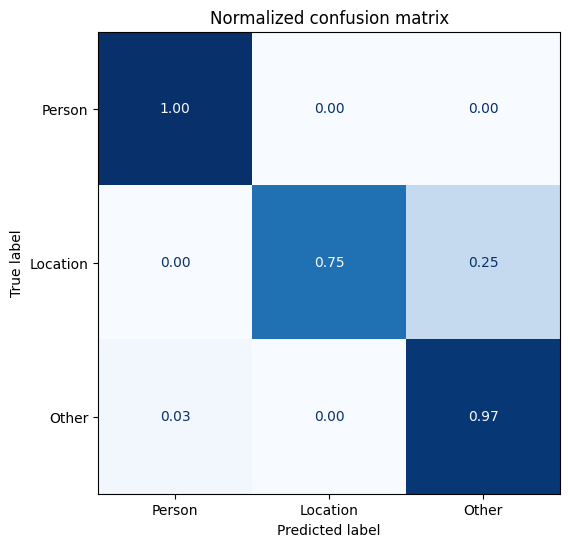

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ['Person', 'Location', 'Other']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(segments_encoded["test"]["label"])

plot_confusion_matrix(y_preds, y_valid, labels)

In [24]:
label2idx = {
    'Person': 0,
    'Location': 1,
    'Other': 2
}

idx2label = {
    0: 'Person',
    1: 'Location',
    2: 'Other'
}

In [25]:
edition = 1
segments_ed1 = await load_segments(edition, range(1, 1001), get_all=False)

segments_ed1_list = []

for article, value_list in segments_ed1.items():
    for value in value_list:
        value['edition'] = edition
        value['article'] = article
        value['class'] = None
        segments_ed1_list.append(value)

segments_ed1_dataset = Dataset.from_list(segments_ed1_list)

segments_ed1_encoded = segments_ed1_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [26]:
edition = 2
segments_ed2 = await load_segments(edition, range(1, 1001), get_all=False)

segments_ed2_list = []

for article, value_list in segments_ed2.items():
    for value in value_list:
        value['edition'] = edition
        value['article'] = article
        value['class'] = None
        segments_ed2_list.append(value)

segments_ed2_dataset = Dataset.from_list(segments_ed2_list)

segments_ed2_encoded = segments_ed2_dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [37]:
preds_output_ed1 = trainer.predict(segments_ed1_encoded.remove_columns('label'))

  0%|          | 0/125 [00:00<?, ?it/s]

In [190]:
preds_output_ed2 = trainer.predict(segments_ed2_encoded.remove_columns('label'))

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:

np.array(segments_ed2_encoded["label"])

KeyError: "Column test not in the dataset. Current columns in the dataset: ['head', 'raw_text', 'text', 'label', 'qid', 'latitude', 'longitude', 'cross_refs', 'edition', 'article', 'class', 'input_ids', 'token_type_ids', 'attention_mask']"

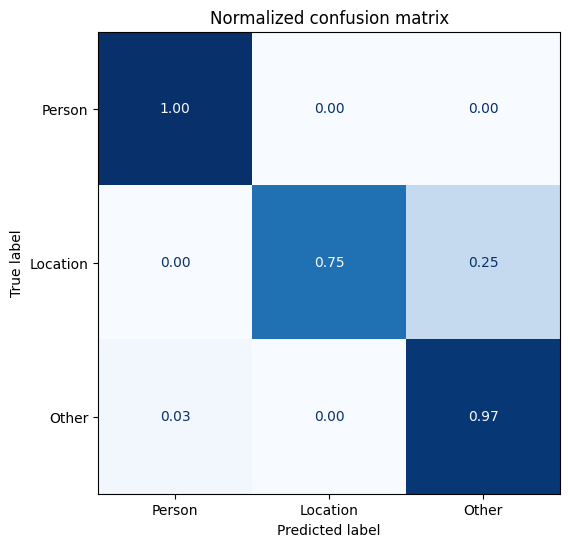

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ['Person', 'Location', 'Other']

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(segments_encoded["test"]["label"])

plot_confusion_matrix(y_preds, y_valid, labels)

In [166]:
y_preds_ed1 = np.argmax(preds_output_ed1.predictions, axis=1)

for entry, label in zip(segments_ed1_list, y_preds_ed1):
    article = entry['article']
    
    segments_ed1[article][0]['class'] = idx2label[label]

In [181]:
save_json('segments', segments_ed1, 1)

In [191]:
y_preds_ed2 = np.argmax(preds_output_ed2.predictions, axis=1)

for entry, label in zip(segments_ed2_list, y_preds_ed2):
    article = entry['article']
    
    segments_ed2[article][0]['class'] = idx2label[label]

In [192]:
save_json('segments', segments_ed2, 2)

In [187]:
from qdrant_client import QdrantClient

client = QdrantClient(":memory:")

tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')
model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')

# Function to generate embeddings for a single batch of data
def generate_embeddings(batch, idx = 'text'):
    inputs = tokenize(batch, idx)
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean of the last hidden state as the embedding
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


In [193]:
client.recreate_collection(
    collection_name="edition_1",
    vectors_config=models.VectorParams(
        size=768,  # Vector size is defined by used model
        distance=models.Distance.COSINE,
    ),
)

client.recreate_collection(
    collection_name="edition_1",
    vectors_config=models.VectorParams(
        size=768,  # Vector size is defined by used model
        distance=models.Distance.COSINE,
    ),
)

C:\Users\kalls\AppData\Local\Temp\ipykernel_5560\3397181592.py:1: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(
C:\Users\kalls\AppData\Local\Temp\ipykernel_5560\3397181592.py:9: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [194]:
client.upload_points(
    collection_name="edition_1",
    points=[
        models.PointStruct(
            id=idx, vector=generate_embeddings(entry).tolist(), payload=entry
        )
        for idx, entry in enumerate(segments_ed1_list)
    ],
)

In [183]:
import keyboard

correct = 0
maximum = len(segments_ed2_list)

for i, entry in enumerate(segments_ed2_list):
    
    hits = client.query_points(
        collection_name="edition_1",
        query=generate_embeddings(entry).tolist(),
        limit=1,
    ).points
    
    
    for hit in hits:
        print(f"{i}/{len(segments_ed2_dataset)}: ed2 \'{entry['head']}\' was matched against ed1 \'{hit.payload['head']}\' with a score: {hit.score}")
        
    print('Press 1 if this is correct and 2 otherwise:\n')
    
    while(True):
        key_press = keyboard.read_key()

        if key_press in {'1', '2'}:
            correct += key_press == '1'
            break
    
        

AttributeError: 'SequenceClassifierOutput' object has no attribute 'last_hidden_state'

In [120]:
correct / maximum

0.58

In [24]:
seg_ed1 = load_json('segments', 1, range(1, 1001))
seg_ed2 = load_json('segments', 2, range(1, 1001))

In [28]:
save_json('segments_small', seg_ed1, 1)
save_json('segments_small', seg_ed2, 2)